# Run the simulations

In [84]:
!make typical tfs mc -j 3

test -d ../../work/xsch || mkdir ../../work/xsch
cd ../../work/ && make xsch LIB=JNW_GREX_SKY130A CELL=JNW_GREX
xschem -q -x -b -s -n ../design/JNW_GREX_SKY130A/JNW_GREX.sch
cp xsch/JNW_GREX.spice xsch/JNW_GREX.spice.bak
cat xsch/JNW_GREX.spice.bak | perl ../tech/script/fixsubckt > xsch/JNW_GREX.spice
rm xsch/JNW_GREX.spice.bak
perl ../../tech/script/genxdut ../../work/xsch/JNW_GREX.spice JNW_GREX
cicsim run --name Sch_typical tran  Sch Gt Ktt Tt Vt
Available replacements {cic(runsim|runmeas|corner|index|testbench|rundir|sha|shas|oldsha|name|oname)}
Replacing {cicname} = tran_SchGtKttTtVt
Info: No spice files have changed
Info: Skipping simulation of tran_SchGtKttTtVt.spi
Replacing {cicname} = tran_SchGtKttTtVt
Info: No meas files have changed
Info: Skipping measurement run of tran_SchGtKttTtVt.meas
Info: Not storing sha file, no simulation run
Writing output_tran/tran_SchGtKttTtVt.yaml
Total simulation time : 0:00:00.030446
Running tran.py with output_tran/tran_SchGtKttTtVt
|   tpulse

# Code for plotting curves

In [85]:
#!/usr/bin/env python3
import yaml
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot(frun,calvector=None):

    files = list()
    with open(frun) as fi:
        for line in fi:
            if(line.startswith("*")):
                continue
            files.append(line.strip() + ".yaml")


    fig,ax = plt.subplots(nrows=2,ncols=1,sharex=True,height_ratios=[4,1],figsize=(16,9))

    for fname in files:
        with open(fname) as fi:
            obj = yaml.safe_load(fi)
        data = dict()
        vals = list()
        offset = 0
        vdd = 1.8
        for k in obj:
            if("vdd" in k):
                vdd = obj[k]
            if("tpulse" in k):
                (dd,v) = k.split("tpulse_")
                dv = int(v)
                vals.append([dv,obj[k]])
                if(dv==20):
                    offset = obj[k]

        df = pd.DataFrame(vals, columns=['x','y'])
        df = df.sort_values(by=['x', 'y'])
        df["y"] = df["y"] - offset

        df["est"] = 0
        if(calvector is None):
            d["est"] = d["y"]
        else:
            for k in range(0,len(calvector)):
                df["est"] += np.power(df["y"],len(calvector)-k-1)*calvector[k]


        diff = df["est"] - df["x"]

        ax[0].plot(df["x"],df["est"],label=fname)
        ax[1].plot(df["x"],diff)



    ax[0].set_title(frun.replace(".run",""))
    plt.xlabel("Temperature [C]")
    ax[0].set_ylabel("Estimate [C]")
    ax[1].set_ylabel("Error [C]")
    ax[0].grid()
    ax[1].grid()
    ax[0].legend(loc='upper left')
    plt.tight_layout()
    plt.savefig(frun.replace(".run",".svg"))
    plt.show()


# Typical

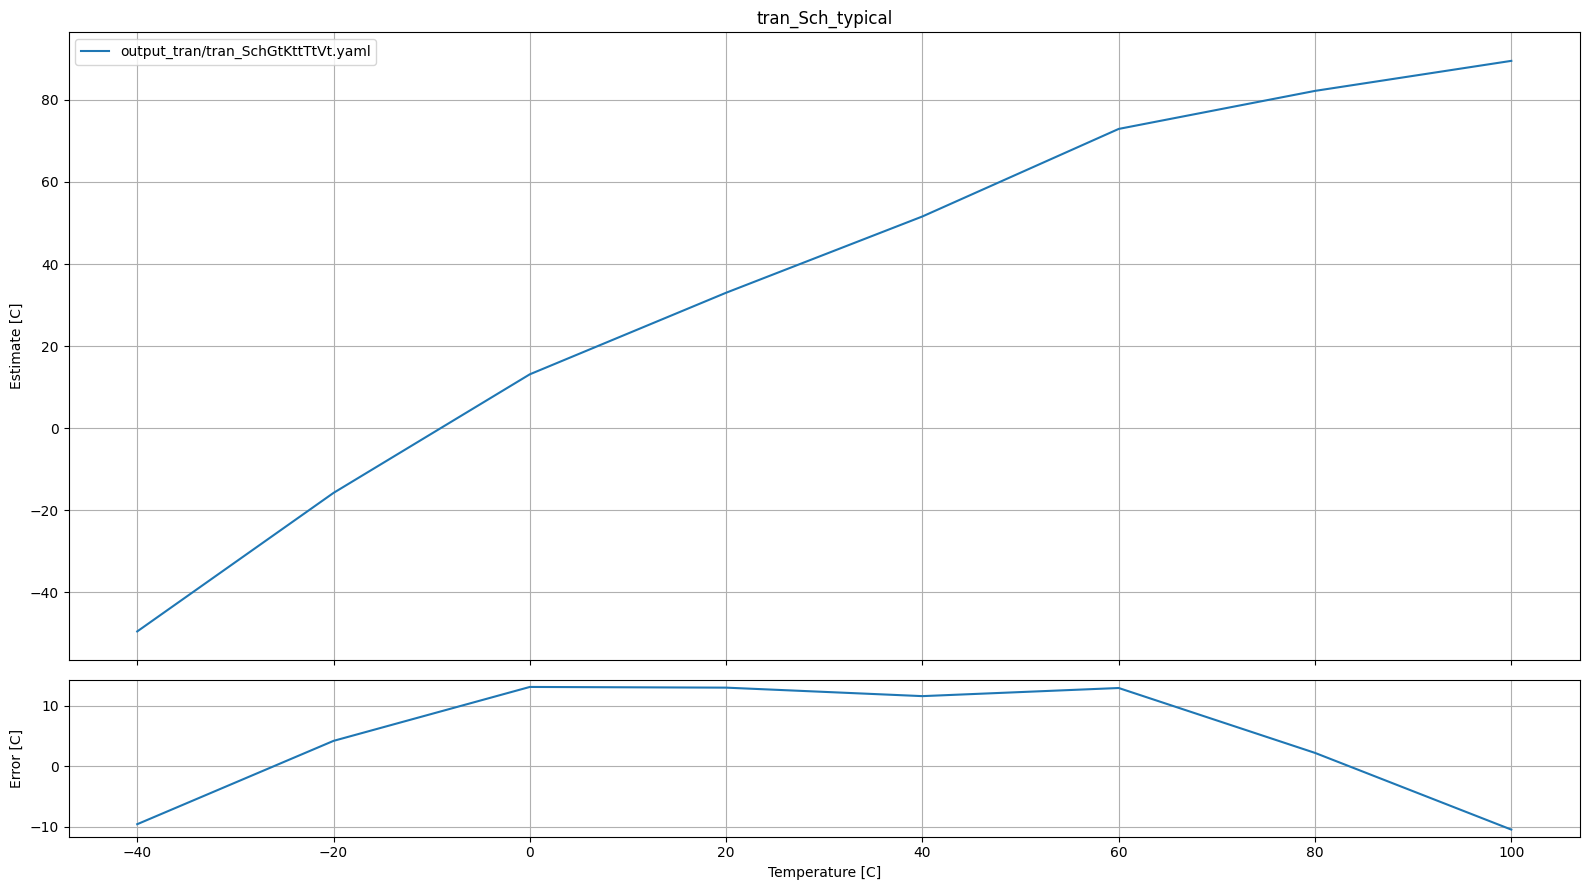

In [86]:
calvector = [-8e8,33]
plot("tran_Sch_typical.run",calvector)

# Slow/Fast

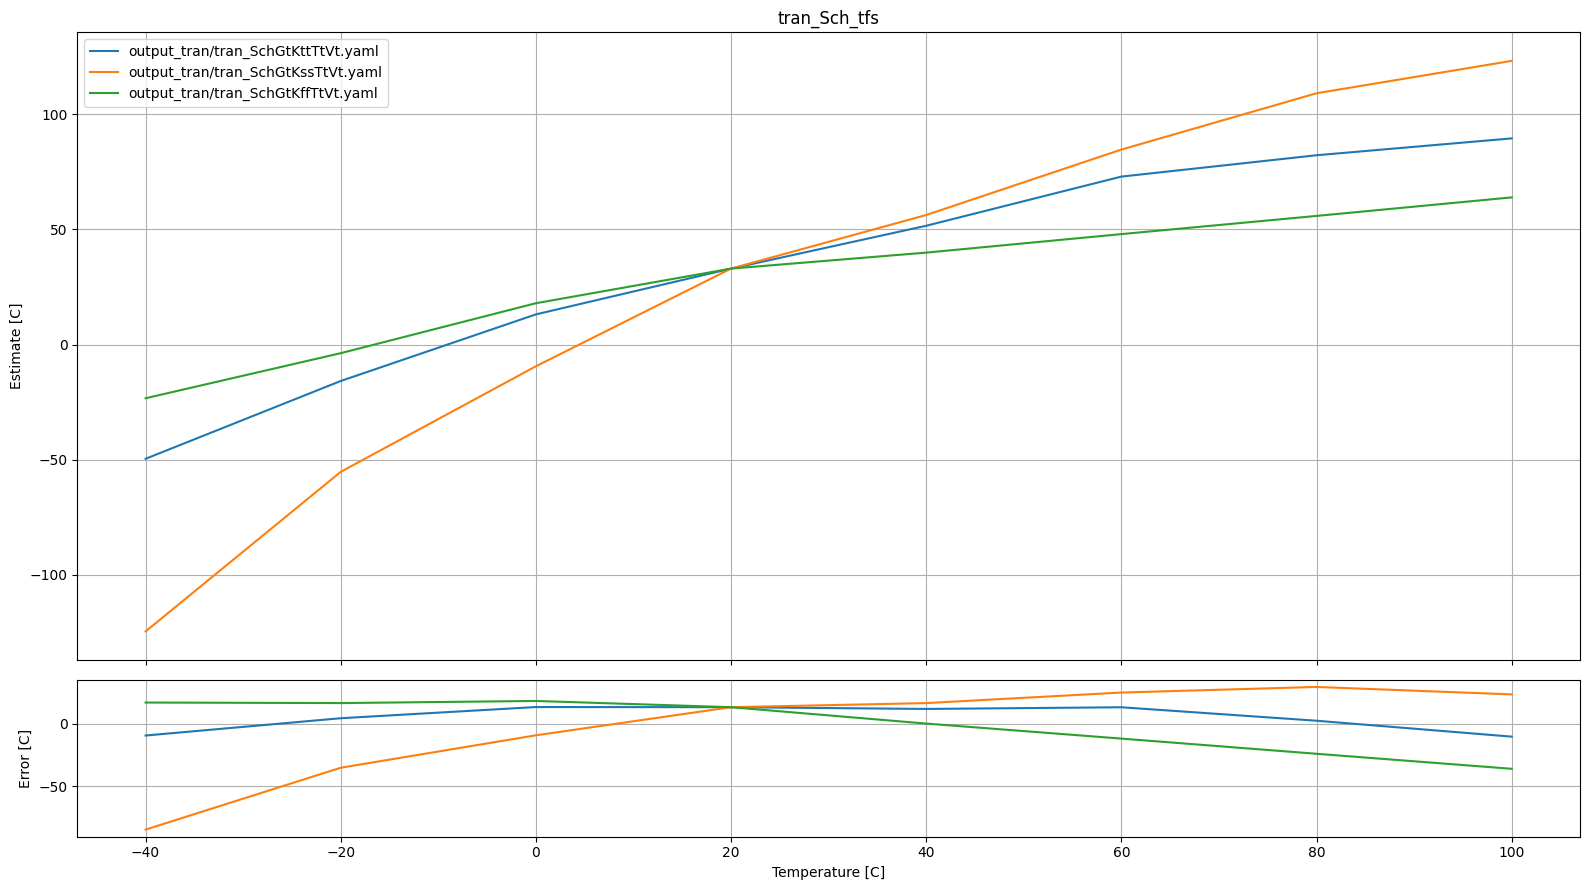

In [87]:
plot("tran_Sch_tfs.run",calvector)

# Monte Carlo

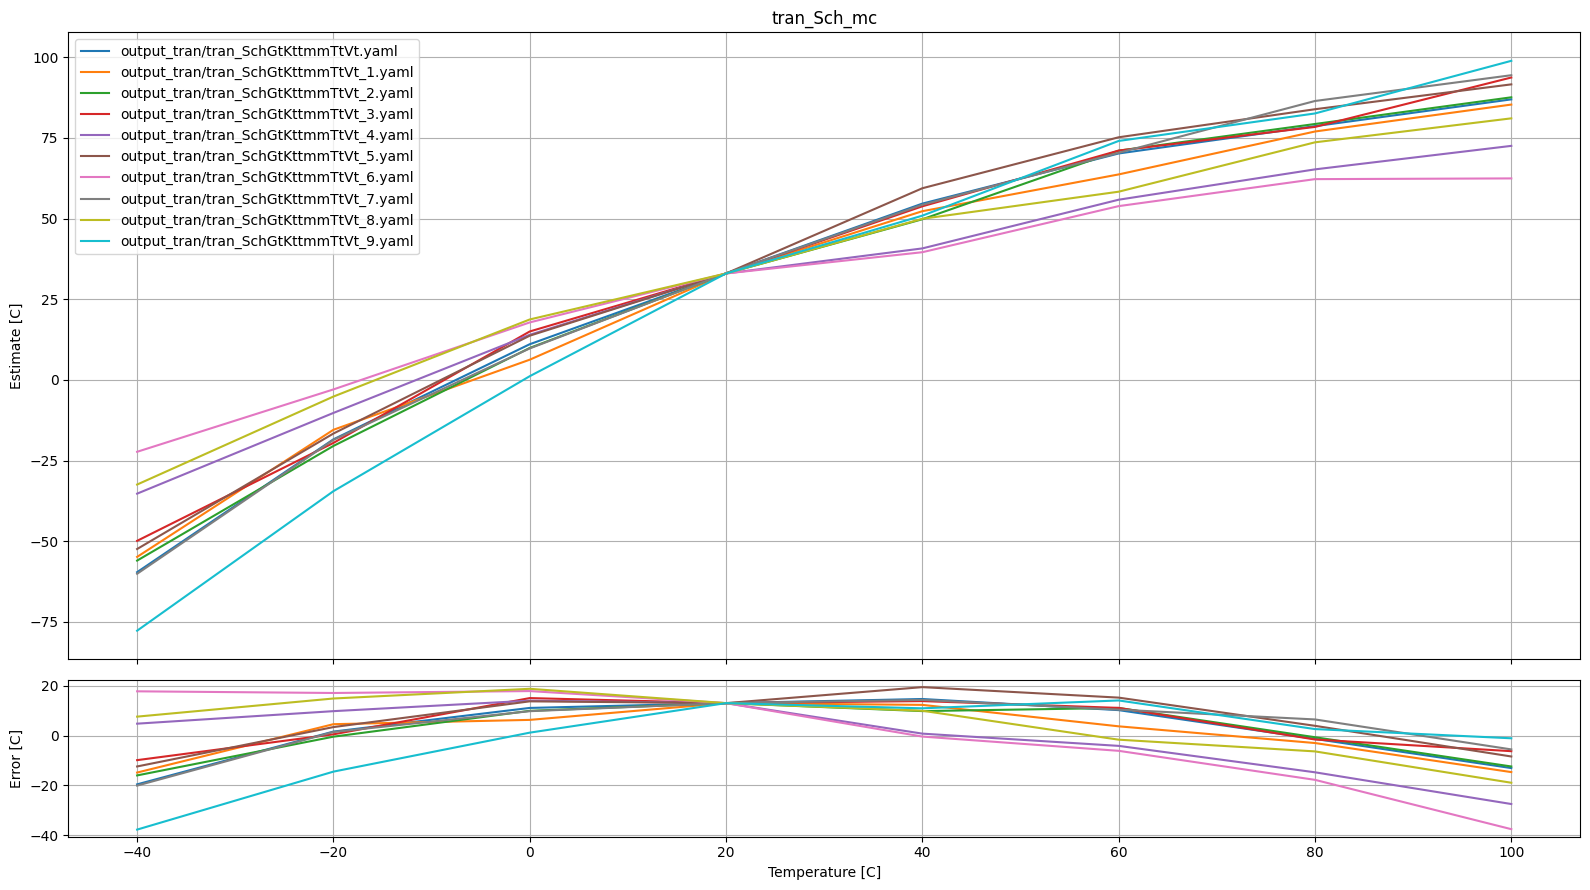

In [88]:
plot("tran_Sch_mc.run",calvector)